#### Introduction: To leverage a CycleGan network to transform real photos to a style akin to Monet paintings.  To accomplish this, three separate sub models are needed.  Two are discriminator models.  One is built to be able to identify Money paintings, and another is used to identify real photos.  In addition, 2 generator models are created.  One to transform a Monet painting to appear real, and another to transform real photos to be like Monet paintings.  

## Dependencies

In [1]:
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers

2024-04-02 11:50:02.634338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 11:50:02.634397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 11:50:02.686719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 11:50:02.799187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 11:50:03.829275: W tensorflow/compiler/tf2

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2024-04-02 11:50:04.879423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 11:50:05.018905: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 11:50:05.018982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 11:50:06.414028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 11:50:06.414129: I external/local_xla/xla/stream_executor

## TPU configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS: 1


# Model parameters

In [4]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 10 #lower epochs due to memory errors
BATCH_SIZE = 1

# Load data

### Use numpy in order to perform some EDA on the pictures

In [ ]:
GCS_PATH = os.getcwd()

monet_dataset = []
photo_dataset = []

monet_file_list = os.listdir(GCS_PATH  + '/Data/monet_jpg/')
monet_file_list2 = []
for i in range(0,len(monet_file_list)):
    if monet_file_list[i].endswith(('.jpg')):
        monet_file_list2.append( monet_file_list[i])
        im = Image.open(GCS_PATH + '/Data/monet_jpg/' + monet_file_list[i]) 
        np_img = np. array(im)
        monet_dataset.append(np_img)

photo_file_list = os.listdir(GCS_PATH  + '/Data/photo_jpg/')
photo_file_list2 = []
for i in range(0,len(monet_file_list)):
    if photo_file_list[i].endswith(('.jpg')):
        photo_file_list2.append(photo_file_list[i])
        im = Image.open(GCS_PATH + '/Data/photo_jpg/' + photo_file_list[i]) 
        np_img = np. array(im)
        photo_dataset.append(np_img)

In [63]:
np.mean(np.mean(np.mean(monet_dataset, axis = 1), axis = 0), axis = 0)

array([132.96300456, 133.72787954, 121.57267919])

In [64]:
np.mean(np.mean(np.mean(photo_dataset, axis = 1), axis = 0), axis = 0)

array([102.4412617 , 104.91112211,  99.01228015])

#### Monet paintings appear to be much more color saturated vs. photos

### Generate Tensor objects from the files

In [5]:
GCS_PATH = os.getcwd()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/Data/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/Data/photo_tfrec/*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


## Auxiliar functions

In [6]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1
                

# Model functions
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(L.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(L.Dropout(0.5))

    result.add(L.ReLU())

    return result

## Looking at a few Monet paintings

2024-04-02 11:50:30.914927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 11:50:30.915042: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 11:50:30.915078: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 11:50:30.915228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 11:50:30.915262: I external/local_xla/xla/stream_executor

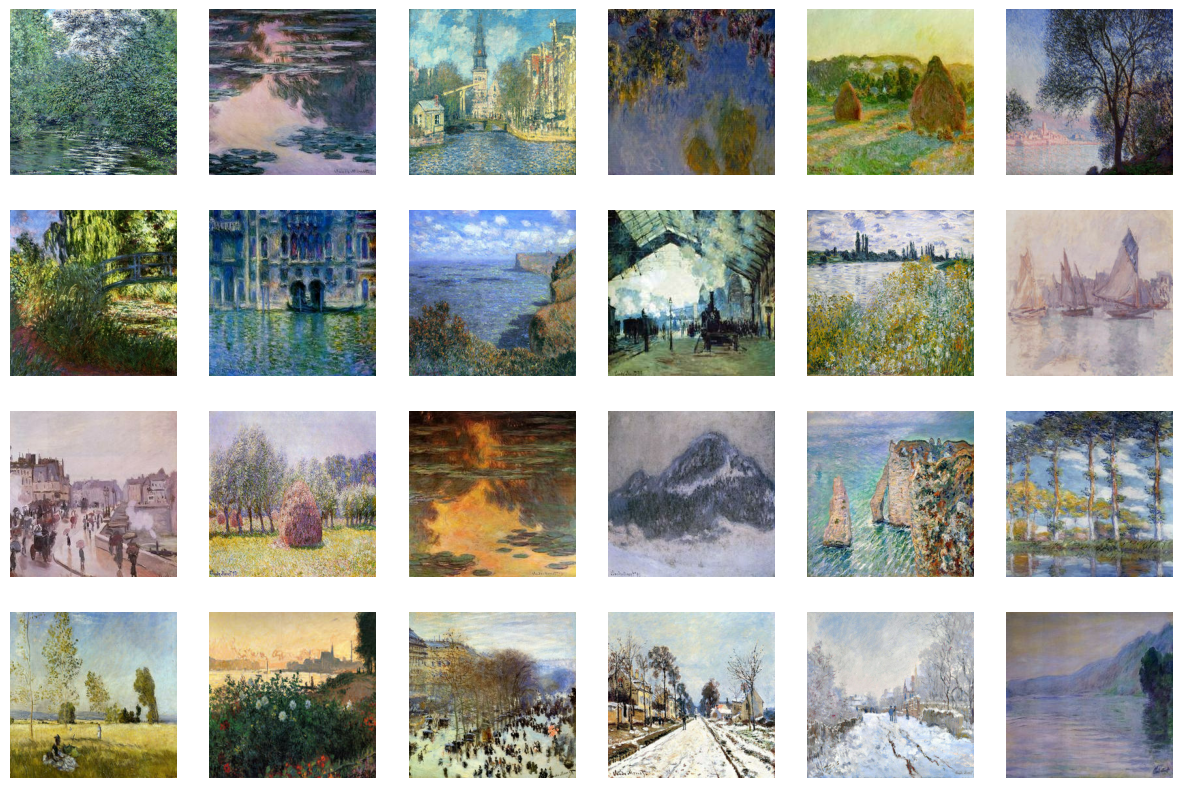

In [7]:
display_samples(load_dataset(MONET_FILENAMES).batch(1), 4, 6)

## Looking at a few photo samples

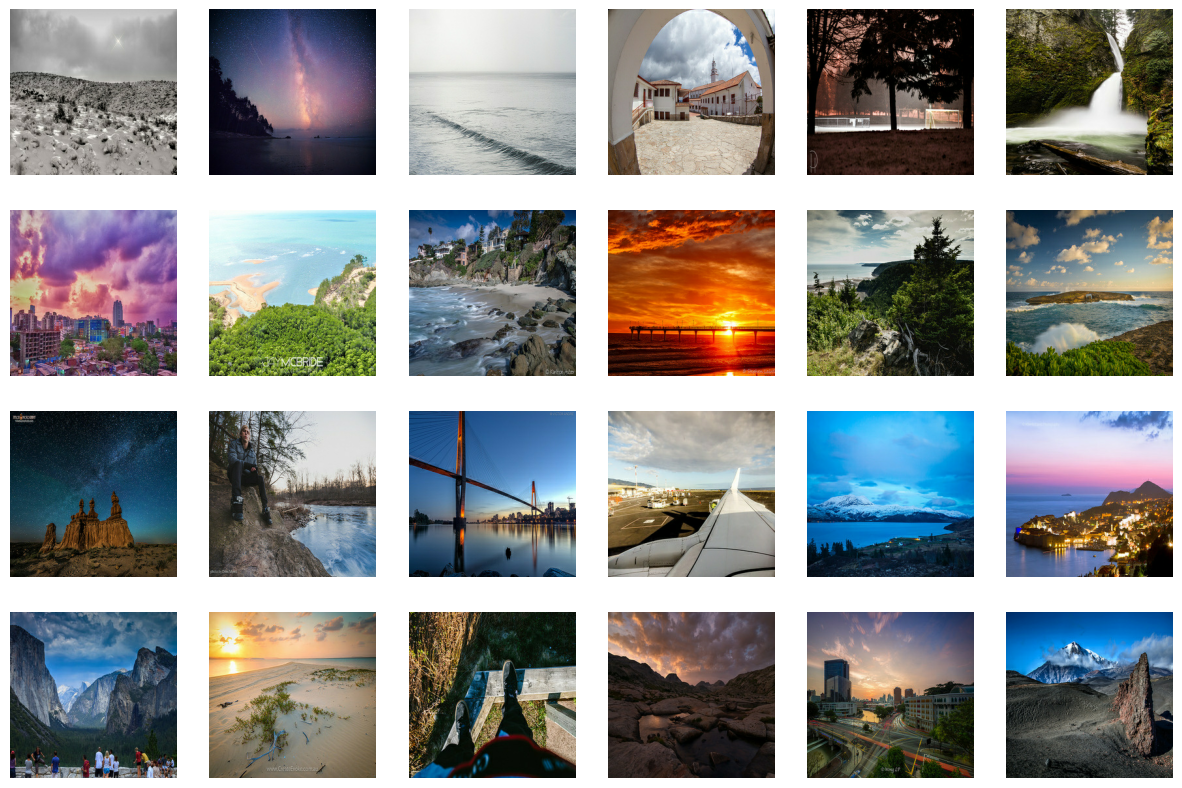

In [8]:
display_samples(load_dataset(PHOTO_FILENAMES).batch(1), 4, 6)

In [67]:
monet_dataset[0].shape

(256, 256, 3)

# Generator model

In [9]:
OUTPUT_CHANNELS = 3

def generator_fn():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)
        downsample(512, 4),                          # (bs, 16, 16, 512)
        downsample(512, 4),                          # (bs, 8, 8, 512)
        downsample(512, 4),                          # (bs, 4, 4, 512)
        downsample(512, 4),                          # (bs, 2, 2, 512)
        downsample(512, 4),                          # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4),                     # (bs, 16, 16, 1024)
        upsample(256, 4),                     # (bs, 32, 32, 512)
        upsample(128, 4),                     # (bs, 64, 64, 256)
        upsample(64, 4),                      # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = L.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

# Discriminator model

In [10]:
def discriminator_fn():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = L.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = L.Conv2D(512, 4, strides=1,
                    kernel_initializer=initializer,
                    use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = L.LeakyReLU()(norm1)

    zero_pad2 = L.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = L.Conv2D(1, 4, strides=1,
                    kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return Model(inputs=inp, outputs=last)

# Build model (CycleGAN)

In [11]:
with strategy.scope():
    monet_generator = generator_fn() # transforms photos to Monet-esque paintings
    photo_generator = generator_fn() # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn() # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }

# Loss functions

In [12]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

# Train

In [13]:
with strategy.scope():
    # Create generators
    monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

    # Create discriminators
    monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)
    

history = gan_model.fit(get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_monet_samples//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=2).history

Epoch 1/10


2024-04-02 11:50:51.200135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-02 11:50:55.519083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-02 11:50:56.703867: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-04-02 11:50:57.475125: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-04-02 11:51:00.113984: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the availabl

300/300 - 158s - monet_gen_loss: 4.8062 - photo_gen_loss: 5.0422 - monet_disc_loss: 0.5895 - photo_disc_loss: 0.5906 - 158s/epoch - 527ms/step
Epoch 2/10
300/300 - 120s - monet_gen_loss: 3.0760 - photo_gen_loss: 3.1706 - monet_disc_loss: 0.7467 - photo_disc_loss: 0.7982 - 120s/epoch - 400ms/step
Epoch 3/10
300/300 - 117s - monet_gen_loss: 3.7420 - photo_gen_loss: 3.7212 - monet_disc_loss: 0.6491 - photo_disc_loss: 0.4195 - 117s/epoch - 390ms/step
Epoch 4/10
300/300 - 117s - monet_gen_loss: 4.3149 - photo_gen_loss: 4.5696 - monet_disc_loss: 0.5093 - photo_disc_loss: 0.4507 - 117s/epoch - 391ms/step
Epoch 5/10
300/300 - 117s - monet_gen_loss: 3.1510 - photo_gen_loss: 3.6302 - monet_disc_loss: 0.3050 - photo_disc_loss: 0.3455 - 117s/epoch - 391ms/step
Epoch 6/10
300/300 - 117s - monet_gen_loss: 4.3806 - photo_gen_loss: 3.1681 - monet_disc_loss: 0.5740 - photo_disc_loss: 0.5598 - 117s/epoch - 391ms/step
Epoch 7/10
300/300 - 117s - monet_gen_loss: 3.2224 - photo_gen_loss: 2.9565 - monet_dis

2024-04-02 12:10:53.147033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-02 12:10:53.154176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Visualize predictions

1/1 [==============================] - 1s 1s/step


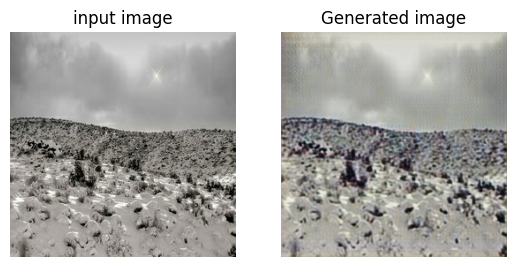

1/1 [==============================] - 0s 33ms/step


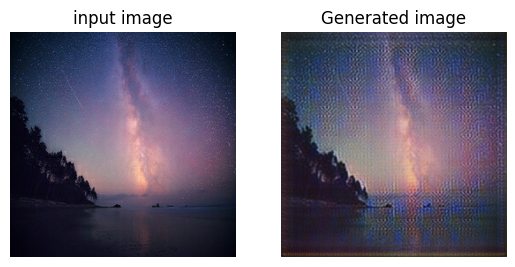

1/1 [==============================] - 0s 26ms/step


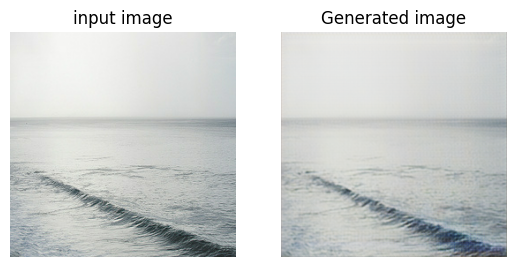

1/1 [==============================] - 0s 24ms/step


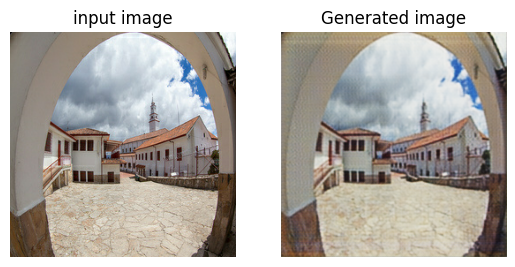

1/1 [==============================] - 0s 25ms/step


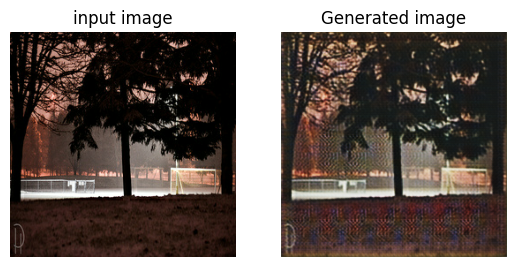

1/1 [==============================] - 0s 19ms/step


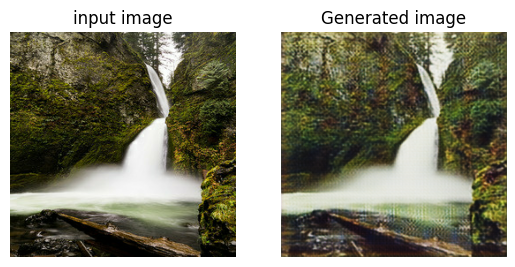

1/1 [==============================] - 0s 23ms/step


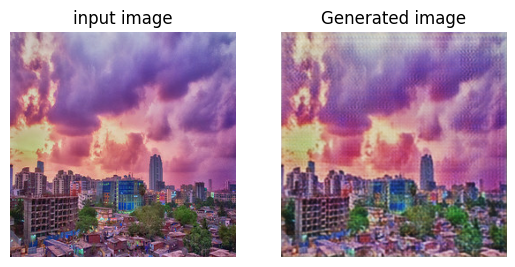

1/1 [==============================] - 0s 18ms/step


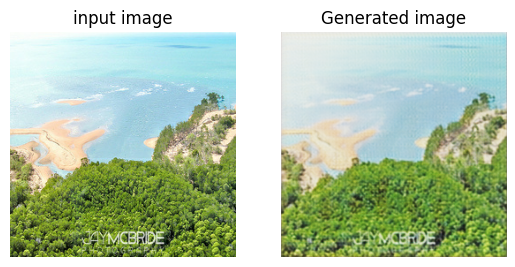

In [14]:
display_generated_samples(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, 8)

## Make predictions

In [68]:
#os.makedirs('../images/') # Create folder to save generated images

predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

### In conclusion, much of the code had been borrowed from Amy Jang's notebook, and I made tweaks to the configurations in attempts to improve performance on my hardware. As is, my hardware was insufficient as this type of model requires significant memory resources in order to execute.  I had to reduce the number of epochs as the model broke at 17.  Adding more down sample layers also helped, but the reduced granularity had an inverse impact on the model's capability to generate believable Monet type images